In [1]:
import polars as pl
import vowpal_wabbit_next as vw

In [2]:
import random

# Generate a random float between 10.5 and 75.5
boundl = 0
boundr = 2
random_float = random.uniform(boundl, boundr)
initial_data = [{"d1": random.uniform(boundl, boundr), "d2": random.uniform(boundl, boundr)} for _ in range(4)]

initial_df = pl.DataFrame(initial_data).with_row_index()

initial_df

index,d1,d2
u32,f64,f64
0,0.892529,1.756183
1,1.983776,1.371866
2,0.24193,1.910263
3,1.416961,0.081715


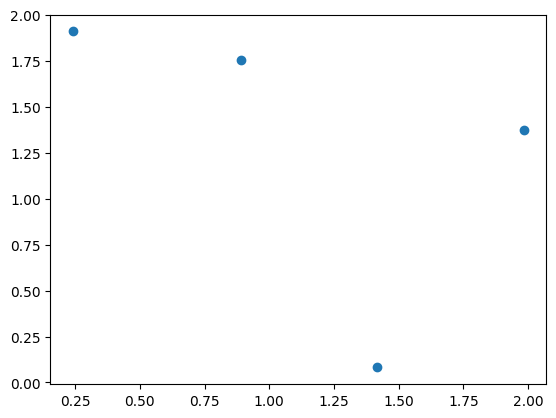

In [3]:
import matplotlib.pyplot as plt

plt.scatter('d1', 'd2', data=initial_df)
plt.show()

In [4]:
from typing import List

def parse_lines(parser: vw.TextFormatParser, input_str: str) -> List[vw.Example]:
    return [parser.parse_line(line) for line in input_str.split("\n")]

def to_vw_item_format(context, actions, cb_label=None):
    if cb_label is not None:
        chosen_action, cost, prob = cb_label
        # print("chosen")
        # print(chosen_action)
    example_string = ""
    example_string += "shared |Item d1={} d2={}\n".format(
        context["d1"],
        context["d2"]
    )
    for action in actions:
        # print("stuff is happening")
        # print(action)
        #print(action["id"], chosen_action["id"] if cb_label else None)
        if cb_label is not None and action["id"] == chosen_action["id"]:
            #print("reached probability change")
            example_string += "0:{}:{} ".format(cost, prob)
        
        example_string += "|Cluster m1={} m2={} \n".format(
            action["m1"],
            action["m2"]
        )
    # Strip the last newline
    return example_string[:-1]

context = {"d1": 0.2, "d2": 0.9}
actions = [{"id": "cluster_1", "m1": 1, "m2": 1}, {"id": "cluster_2", "m1": context["d1"], "m2": context["d2"]}]

print(to_vw_item_format(context, actions))

shared |Item d1=0.2 d2=0.9
|Cluster m1=1 m2=1 
|Cluster m1=0.2 m2=0.9 


In [5]:
from typing import List, Tuple

def sample_custom_pmf(pmf: List[Tuple[int, float]]) -> Tuple[int, float]:
    values = [x for (_, x) in pmf]
    total = sum(values)
    scale = 1 / total
    values = [x * scale for x in values]
    draw = random.random()
    sum_prob = 0.0
    for index, prob in enumerate(values):
        sum_prob += prob
        if sum_prob > draw:
            return pmf[index][0], prob

def get_action(workspace: vw.Workspace, parser: vw.TextFormatParser, context, actions):
    pmf = workspace.predict_one(
        parse_lines(parser, to_vw_item_format(context, actions))
    )
    chosen_action_index, prob = sample_custom_pmf(pmf)
    return actions[chosen_action_index], prob

In [31]:
workspace = vw.Workspace(["--cb_explore_adf", "--epsilon", "0.2"])
parser = vw.TextFormatParser(workspace)

In [32]:
medoids = []

for row in initial_df.iter_rows(named=True):
    actions = medoids + [{"id": "new_cluster", "m1": row["d1"], "m2": row["d2"]}]

    action, prob = get_action(workspace, parser, row, actions)

    print(action, prob)

    cost = -0.01
    if action["id"] == "new_cluster":
        cost = 0.02
        action["id"] = f"cluster_{len(medoids)}"
        medoids.append(action)

    vw_format = to_vw_item_format(context, actions, (action, cost, prob))
    # 6. Learn
    workspace.learn_one(parse_lines(parser, vw_format))

    #print(medoids)

{'id': 'new_cluster', 'm1': 0.8925286620948831, 'm2': 1.756183391237627} 1.0
{'id': 'new_cluster', 'm1': 1.9837759699857223, 'm2': 1.3718661602270656} 0.9000000022351741
{'id': 'new_cluster', 'm1': 0.24192975831861907, 'm2': 1.9102632828009953} 0.866666661699613
{'id': 'new_cluster', 'm1': 1.4169609485946946, 'm2': 0.08171493166372135} 0.8500000016763806


In [33]:
medoids

[{'id': 'cluster_0', 'm1': 0.8925286620948831, 'm2': 1.756183391237627},
 {'id': 'cluster_1', 'm1': 1.9837759699857223, 'm2': 1.3718661602270656},
 {'id': 'cluster_2', 'm1': 0.24192975831861907, 'm2': 1.9102632828009953},
 {'id': 'cluster_3', 'm1': 1.4169609485946946, 'm2': 0.08171493166372135}]

In [34]:
def recluster(workspace: vw.Workspace, parser: vw.TextFormatParser, context, actions, action):
    new_action = False
    if action["id"] == "new_cluster":
        new_action = True
        action["id"] = f"cluster_{len(actions)}"
        #actions.append(action)
    
    current_actions = actions.copy() + [action]

    pred_action, prob = get_action(workspace, parser, row, current_actions)

    print(pred_action, prob)

    #print("actions before:", actions)
    if new_action:
        print("new?")
        actions.append(action)
    #print("actions after:", actions)
    
    cost = -0.1
    prob = 1
    print(action)
    vw_format = to_vw_item_format(context, actions, (action, cost, prob))
    print(vw_format)
    # 6. Learn
    workspace.learn_one(parse_lines(parser, vw_format))

In [35]:
user_context = initial_df.row(3, named=True)
user_action = medoids[0]
recluster(workspace, parser, user_context, medoids, user_action)

{'id': 'cluster_3', 'm1': 1.4169609485946946, 'm2': 0.08171493166372135} 0.84000000834465
{'id': 'cluster_0', 'm1': 0.8925286620948831, 'm2': 1.756183391237627}
shared |Item d1=1.4169609485946946 d2=0.08171493166372135
0:-0.1:1 |Cluster m1=0.8925286620948831 m2=1.756183391237627 
|Cluster m1=1.9837759699857223 m2=1.3718661602270656 
|Cluster m1=0.24192975831861907 m2=1.9102632828009953 
|Cluster m1=1.4169609485946946 m2=0.08171493166372135 


In [36]:
for row in initial_df.iter_rows(named=True):
    #actions = medoids + [{"id": "new_cluster", "m1": row["d1"], "m2": row["d2"]}]
    actions = medoids.copy()

    action, prob = get_action(workspace, parser, row, actions)

    print(action, prob)

    cost = -0.01
    if action["id"] == "new_cluster":
        cost = 0.02
        action["id"] = f"cluster_{len(medoids)}"
        medoids.append(action)

    vw_format = to_vw_item_format(context, actions, (action, cost, prob))
    # 6. Learn
    workspace.learn_one(parse_lines(parser, vw_format))

    #print(medoids)

{'id': 'cluster_2', 'm1': 0.24192975831861907, 'm2': 1.9102632828009953} 0.04999999944120647
{'id': 'cluster_0', 'm1': 0.8925286620948831, 'm2': 1.756183391237627} 0.8500000016763806
{'id': 'cluster_1', 'm1': 1.9837759699857223, 'm2': 1.3718661602270656} 0.04999999944120647
{'id': 'cluster_0', 'm1': 0.8925286620948831, 'm2': 1.756183391237627} 0.8500000016763806


In [37]:
user_context = initial_df.row(0, named=True)
user_action = medoids[1]
recluster(workspace, parser, user_context, medoids, user_action)

{'id': 'cluster_0', 'm1': 0.8925286620948831, 'm2': 1.756183391237627} 0.84000000834465
{'id': 'cluster_1', 'm1': 1.9837759699857223, 'm2': 1.3718661602270656}
shared |Item d1=0.8925286620948831 d2=1.756183391237627
|Cluster m1=0.8925286620948831 m2=1.756183391237627 
0:-0.1:1 |Cluster m1=1.9837759699857223 m2=1.3718661602270656 
|Cluster m1=0.24192975831861907 m2=1.9102632828009953 
|Cluster m1=1.4169609485946946 m2=0.08171493166372135 


In [38]:
for row in initial_df.iter_rows(named=True):
    #actions = medoids + [{"id": "new_cluster", "m1": row["d1"], "m2": row["d2"]}]
    actions = medoids.copy()

    action, prob = get_action(workspace, parser, row, actions)

    print(action, prob)

    cost = -0.01
    if action["id"] == "new_cluster":
        cost = 0.02
        action["id"] = f"cluster_{len(medoids)}"
        medoids.append(action)

    vw_format = to_vw_item_format(context, actions, (action, cost, prob))
    # 6. Learn
    workspace.learn_one(parse_lines(parser, vw_format))

    #print(medoids)

{'id': 'cluster_1', 'm1': 1.9837759699857223, 'm2': 1.3718661602270656} 0.8500000016763806
{'id': 'cluster_1', 'm1': 1.9837759699857223, 'm2': 1.3718661602270656} 0.8500000016763806
{'id': 'cluster_1', 'm1': 1.9837759699857223, 'm2': 1.3718661602270656} 0.8500000016763806
{'id': 'cluster_1', 'm1': 1.9837759699857223, 'm2': 1.3718661602270656} 0.8500000016763806


In [39]:
user_context = initial_df.row(1, named=True)
user_action = {"id": "new_cluster", "m1": user_context["d1"], "m2": user_context["d2"]}
recluster(workspace, parser, user_context, medoids, user_action)

{'id': 'cluster_1', 'm1': 1.9837759699857223, 'm2': 1.3718661602270656} 0.44000000089406965
new?
{'id': 'cluster_4', 'm1': 1.9837759699857223, 'm2': 1.3718661602270656}
shared |Item d1=1.9837759699857223 d2=1.3718661602270656
|Cluster m1=0.8925286620948831 m2=1.756183391237627 
|Cluster m1=1.9837759699857223 m2=1.3718661602270656 
|Cluster m1=0.24192975831861907 m2=1.9102632828009953 
|Cluster m1=1.4169609485946946 m2=0.08171493166372135 
0:-0.1:1 |Cluster m1=1.9837759699857223 m2=1.3718661602270656 


In [40]:
for row in initial_df.iter_rows(named=True):
    #actions = medoids + [{"id": "new_cluster", "m1": row["d1"], "m2": row["d2"]}]
    actions = medoids.copy()

    action, prob = get_action(workspace, parser, row, actions)

    print(action, prob)

    cost = -0.01
    if action["id"] == "new_cluster":
        cost = 0.02
        action["id"] = f"cluster_{len(medoids)}"
        medoids.append(action)

    vw_format = to_vw_item_format(context, actions, (action, cost, prob))
    # 6. Learn
    workspace.learn_one(parse_lines(parser, vw_format))

    #print(medoids)

{'id': 'cluster_4', 'm1': 1.9837759699857223, 'm2': 1.3718661602270656} 0.44000000089406965
{'id': 'cluster_4', 'm1': 1.9837759699857223, 'm2': 1.3718661602270656} 0.44000000089406965
{'id': 'cluster_1', 'm1': 1.9837759699857223, 'm2': 1.3718661602270656} 0.44000000089406965
{'id': 'cluster_4', 'm1': 1.9837759699857223, 'm2': 1.3718661602270656} 0.44000000089406965


In [ ]:
user_context = initial_df.row(1, named=True)
user_action = {"id": "new_cluster", "m1": user_context["d1"], "m2": user_context["d2"]}
recluster(workspace, parser, user_context, medoids, user_action)

In [10]:
initial_df.row(0, named=True)

{'index': 0, 'd1': 0.8925286620948831, 'd2': 1.756183391237627}

In [11]:
medoids

[{'id': 'cluster_0', 'm1': 0.8925286620948831, 'm2': 1.756183391237627},
 {'id': 'cluster_1', 'm1': 1.9837759699857223, 'm2': 1.3718661602270656},
 {'id': 'cluster_2', 'm1': 0.24192975831861907, 'm2': 1.9102632828009953},
 {'id': 'cluster_3', 'm1': 1.4169609485946946, 'm2': 0.08171493166372135},
 {'id': 'cluster_4', 'm1': 1.9837759699857223, 'm2': 1.3718661602270656}]

In [30]:
for row in initial_df.iter_rows(named=True):
    actions = medoids + [{"id": "new_cluster", "m1": row["d1"], "m2": row["d2"]}]

    action, prob = get_action(workspace, parser, row, actions)

    print(action, prob)

    cost = -0.01
    if action["id"] == "new_cluster":
        cost = 0.02
        action["id"] = f"cluster_{len(medoids)}"
        medoids.append(action)

    vw_format = to_vw_item_format(context, actions, (action, cost, prob))
    # 6. Learn
    workspace.learn_one(parse_lines(parser, vw_format))

    #print(medoids)

{'id': 'cluster_1', 'm1': 1.9837759699857223, 'm2': 1.3718661602270656} 0.28888888963394693
{'id': 'cluster_6', 'm1': 1.9837759699857223, 'm2': 1.3718661602270656} 0.2222222218083011
{'id': 'cluster_6', 'm1': 1.9837759699857223, 'm2': 1.3718661602270656} 0.28888888963394693
{'id': 'cluster_1', 'm1': 1.9837759699857223, 'm2': 1.3718661602270656} 0.28888888963394693


In [13]:
medoids

[{'id': 'cluster_0', 'm1': 0.8925286620948831, 'm2': 1.756183391237627},
 {'id': 'cluster_1', 'm1': 1.9837759699857223, 'm2': 1.3718661602270656},
 {'id': 'cluster_2', 'm1': 0.24192975831861907, 'm2': 1.9102632828009953},
 {'id': 'cluster_3', 'm1': 1.4169609485946946, 'm2': 0.08171493166372135},
 {'id': 'cluster_4', 'm1': 1.9837759699857223, 'm2': 1.3718661602270656},
 {'id': 'cluster_5', 'm1': 1.9837759699857223, 'm2': 1.3718661602270656}]

In [21]:
user_context = initial_df.row(3, named=True)
user_action = medoids[0]
recluster(workspace, parser, user_context, medoids, user_action)

{'id': 'cluster_3', 'm1': 1.4169609485946946, 'm2': 0.08171493166372135} 0.84000000834465
{'id': 'cluster_0', 'm1': 0.8925286620948831, 'm2': 1.756183391237627}
shared |Item d1=1.4169609485946946 d2=0.08171493166372135
0:-0.1:1 |Cluster m1=0.8925286620948831 m2=1.756183391237627 
|Cluster m1=1.9837759699857223 m2=1.3718661602270656 
|Cluster m1=0.24192975831861907 m2=1.9102632828009953 
|Cluster m1=1.4169609485946946 m2=0.08171493166372135 


In [15]:
for row in initial_df.iter_rows(named=True):
    actions = medoids + [{"id": "new_cluster", "m1": row["d1"], "m2": row["d2"]}]

    action, prob = get_action(workspace, parser, row, actions)

    print(action, prob)

    cost = -0.01
    if action["id"] == "new_cluster":
        cost = 0.02
        action["id"] = f"cluster_{len(medoids)}"
        medoids.append(action)

    vw_format = to_vw_item_format(context, actions, (action, cost, prob))
    # 6. Learn
    workspace.learn_one(parse_lines(parser, vw_format))

    #print(medoids)

{'id': 'cluster_4', 'm1': 1.9837759699857223, 'm2': 1.3718661602270656} 0.028571428464991708
{'id': 'cluster_0', 'm1': 0.8925286620948831, 'm2': 1.756183391237627} 0.8285714295293604
{'id': 'cluster_0', 'm1': 0.8925286620948831, 'm2': 1.756183391237627} 0.8285714295293604
{'id': 'cluster_0', 'm1': 0.8925286620948831, 'm2': 1.756183391237627} 0.8285714295293604


In [16]:
def run_simulation(
    workspace: vw.Workspace,
    num_iterations,
    items,
    actions,
    cost_function,
    do_learn=True,
):
    cost_sum = 0.0
    ctr = []

    text_parser = vw.TextFormatParser(workspace)

    for i in range(1, num_iterations + 1):
        # 1. In each simulation choose a user
        item = choose_item(items)
        # 2. Choose time of day for a given user
        time_of_day = choose_time_of_day(times_of_day)

        # 3. Pass context to vw to get an action
        context = {"user": user, "time_of_day": time_of_day}
        action, prob = get_action(workspace, text_parser, context, actions)

        # 4. Get cost of the action we chose
        cost = cost_function(context, action)
        cost_sum += cost

        if do_learn:
            # 5. Inform VW of what happened so we can learn from it
            vw_format = to_vw_example_format(context, actions, (action, cost, prob))
            # 6. Learn
            workspace.learn_one(parse_lines(text_parser, vw_format))

        # We negate this so that on the plot instead of minimizing cost, we are maximizing reward
        ctr.append(-1 * cost_sum / i)

    return ctr